# Learning Rate Schedulers with Skorch 

This notebook demonstrates 3 learning rate schedulers in skorch:

1) StepLR: Reduces learning rate by a factor at fixed steps
2) ReduceLROnPlateau: Adapts learning rate based on model performance
3) Cosine Annealing: Smoothly reduces learning rate using cosine function

Firstly, install the the dependencies and download the datasets.

<a href="" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"></a>


<a href="notebooks/Learning_Rate_Scheduler.ipynb" target="_blank"><img src="https://img.shields.io/github/view/yourusername/yourrepository/main/yourfile.ipynb" alt="View Source on GitHub"></a>


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetClassifier
from sklearn.pipeline import Pipeline
from skorch.callbacks import LRScheduler, Callback
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Learning Rate Schedulers Callback

Firstly, write a function to capture the learning rate at start of each epoch and store them for visualization.

Data Preparation

The dataset will be split into train and test datasets. We will scale the features upto float 32 and labels reshaped for efficient binary classification.

In [8]:
def prepare_data():
    data = load_breast_cancer()
    X, y = data.data, data.target

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    preprocessing_pipeline = Pipeline([
        ('scaler', StandardScaler())
    ])
    X_train_scaled = preprocessing_pipeline.fit_transform(X_train).astype(np.float32)
    X_test_scaled = preprocessing_pipeline.transform(X_test).astype(np.float32)

    y_train = y_train.reshape(-1, 1).astype(np.float32)
    y_test = y_test.reshape(-1, 1).astype(np.float32)

    return X_train_scaled, X_test_scaled, y_train, y_test

In [9]:
class BreastCancerNet(nn.Module):
    def __init__(self, input_dim=30, hidden_dim=64):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, 1)
        )
    
    def forward(self, x):
        return torch.sigmoid(self.layers(x))

# Training Parameters 

1) StepLR:

Reduces the learning rate by a factor (gamma=0.5) every 10 epochs (step_size=10).
Useful for steady, predictable learning rate decay.

2) ReduceLROnPlateau:

Reduces the learning rate dynamically when the model's performance (e.g., loss) plateaus.
Adjusts by a factor (factor=0.5) after 5 epochs of no improvement (patience=5).
Ideal for tasks where loss stagnation indicates the need for smaller learning rates.

3) CosineAnnealing:

Reduces the learning rate in a cosine curve over 10 epochs (T_max=10).
Periodically resets the learning rate, promoting exploration of the loss landscape.

We will train a Binary classifier for 50 epochs and use the Adam optimizer for better convergence. The learning rate is set to 
0.01, but it is dynamically adjusted by the learning rate schedulers.

After training, the score method evaluates the classifier on the test dataset (X_test and y_test), using accuracy as the metric.

In [17]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler

# Define BreastCancerNet model
class BreastCancerNet(nn.Module):
    def __init__(self, input_dim=30, hidden_dim=64):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x):
        return torch.sigmoid(self.layers(x))

# Prepare data
def prepare_data():
    data = load_breast_cancer()
    X, y = data.data, data.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scaling data using a pipeline
    preprocessing_pipeline = Pipeline([('scaler', StandardScaler())])  
    X_train_scaled = preprocessing_pipeline.fit_transform(X_train).astype(np.float32)
    X_test_scaled = preprocessing_pipeline.transform(X_test).astype(np.float32)

    return X_train_scaled, X_test_scaled, y_train.astype(np.float32).reshape(-1, 1), y_test.astype(np.float32).reshape(-1, 1)

# Simulate learning rates with scheduler
def simulate_scheduler(scheduler_class, optimizer_params, steps, initial_lr, X_train, y_train, X_val, y_val, input_dim=30, hidden_dim=64):
    # Create the BreastCancerNet model
    model = BreastCancerNet(input_dim=input_dim, hidden_dim=hidden_dim)
    
    # Initialize the optimizer with the initial learning rate
    optimizer = optim.Adam(model.parameters(), lr=initial_lr)

    # Initialize the scheduler
    scheduler = scheduler_class(optimizer, **optimizer_params)

    # Loss function
    criterion = nn.BCEWithLogitsLoss()

    # Simulate learning rate adjustments over the steps
    lrs = []
    for step in range(steps):
        lrs.append(optimizer.param_groups[0]['lr'])
        
        # Train the model on the training data
        model.train()
        optimizer.zero_grad()
        train_output = model(torch.tensor(X_train, dtype=torch.float32))
        loss = criterion(train_output, torch.tensor(y_train, dtype=torch.float32))
        loss.backward()
        optimizer.step()

        # Compute validation loss
        model.eval()
        with torch.no_grad():
            val_output = model(torch.tensor(X_val, dtype=torch.float32))
            val_loss = criterion(val_output, torch.tensor(y_val, dtype=torch.float32))
        
        # Update the scheduler
        scheduler.step(val_loss)  # For 'ReduceLROnPlateau', it uses the val_loss
    
    return np.array(lrs)

# Train models with different schedulers
def train_schedulers(X_train, X_test, y_train, y_test, lr=0.01, epochs=50, hidden_dim=64):
    # Split the data for validation
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    # Define scheduler parameters for flexibility
    schedulers = [
        {
            "name": "StepLR",
            "scheduler_class": torch.optim.lr_scheduler.StepLR,
            "params": {"step_size": 10, "gamma": 0.5},
        },
        {
            "name": "ReduceLROnPlateau",
            "scheduler_class": torch.optim.lr_scheduler.ReduceLROnPlateau,
            "params": {"mode": "min", "factor": 0.5, "patience": 5},
        },
        {
            "name": "CosineAnnealingLR",
            "scheduler_class": torch.optim.lr_scheduler.CosineAnnealingLR,
            "params": {"T_max": epochs},
        },
    ]

    results = {}
    for scheduler_info in schedulers:
        # Simulate learning rates
        simulated_lrs = simulate_scheduler(
            scheduler_info["scheduler_class"],
            scheduler_info["params"],
            steps=50,
            initial_lr=lr,
            X_train=X_train,
            y_train=y_train,
            X_val=X_val,
            y_val=y_val,
            input_dim=X_train.shape[1],
        )

        print(f"{scheduler_info['name']} Simulated LRs: {simulated_lrs[:5]}...")

        # Modify the neural net classifier with updated parameters
        net = NeuralNetClassifier(
            module=BreastCancerNet,
            max_epochs=epochs,
            lr=lr,
            optimizer=optim.Adam,
            criterion=nn.BCEWithLogitsLoss(),
            callbacks=[LRScheduler(scheduler_info["scheduler_class"], **scheduler_info["params"])]
        )

        # Ensure y_train is 1D
        net.fit(X_train, y_train.reshape(-1, 1))
        score = net.score(X_test, y_test.reshape(-1, 1))

        # Store results
        results[scheduler_info["name"]] = {
            "model": net,
            "simulated_lrs": simulated_lrs,
            "score": score,
        }
        print(f"{scheduler_info['name']} Score: {score:.4f}")

    # Print final results summary
    print("\nFinal Results Summary:")
    for scheduler_name, result in results.items():
        print(f"\nScheduler: {scheduler_name}")
        print(f"Score: {result['score']:.4f}")
        print(f"Simulated Learning Rates: {result['simulated_lrs'][:5]}...")  # Display first 5 values of LR

    return results

# Prepare data
X_train, X_test, y_train, y_test = prepare_data()

# Train and evaluate models with different schedulers
results = train_schedulers(X_train, X_test, y_train, y_test, lr=0.005, epochs=100, hidden_dim=128)


StepLR Simulated LRs: [0.005 0.005 0.005 0.005 0.005]...
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6550       0.6438        0.6205  0.0050  0.0053
      2        0.6216       0.6438        0.5794  0.0050  0.0055
      3        0.5816       0.6438        0.5330  0.0050  0.0054
      4        0.5394       0.6438        0.4981  0.0050  0.0074
      5        0.5089       0.6438        0.4796  0.0050  0.0058
      6        0.4919       0.6712        0.4708  0.0050  0.0059
      7        0.4816       0.6849        0.4665  0.0050  0.0088
      8        0.4747       0.7397        0.4642  0.0050  0.0055
      9        0.4695       0.7671        0.4625  0.0050  0.0064
     10        0.4654       0.7808        0.4612  0.0050  0.0055
     11        0.4634       0.7808        0.4607  0.0025  0.0059
     12        0.4626       0.8082        0.4602  0.0025  0.0056
     13        0.4620       0.808

/home/codespace/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


     18        0.4601       0.8219        0.4578  0.0025  0.0076
     19        0.4597       0.8219        0.4577  0.0025  0.0055
     20        0.4594       0.8356        0.4577  0.0025  0.0064
     21        0.4592       0.8493        0.4577  0.0013  0.0062
     22        0.4591       0.8493        0.4578  0.0013  0.0061
     23        0.4589       0.8493        0.4578  0.0013  0.0057
     24        0.4588       0.8493        0.4578  0.0013  0.0051
     25        0.4587       0.8493        0.4579  0.0013  0.0061
     26        0.4586       0.8493        0.4579  0.0013  0.0093
     27        0.4586       0.8493        0.4579  0.0013  0.0063
     28        0.4585       0.8493        0.4579  0.0013  0.0059
     29        0.4584       0.8493        0.4580  0.0013  0.0057
     30        0.4583       0.8493        0.4580  0.0013  0.0058
     31        0.4583       0.8493        0.4580  0.0006  0.0064
     32        0.4583       0.8493        0.4580  0.0006  0.0061
     33        0.4582    

/home/codespace/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


     19        0.4579       0.9041        0.4579  0.0046  0.0067
     20        0.4577       0.9041        0.4579  0.0046  0.0071
     21        0.4577       0.9178        0.4579  0.0045  0.0058
     22        0.4576       0.9315        0.4579  0.0045  0.0059
     23        0.4575       0.9315        0.4578  0.0044  0.0053
     24        0.4574       0.9315        0.4579  0.0044  0.0105
     25        0.4574       0.9315        0.4579  0.0043  0.0057
     26        0.4572       0.9315        0.4581  0.0043  0.0050
     27        0.4570       0.9315        0.4583  0.0042  0.0057
     28        0.4565       0.9315        0.4585  0.0042  0.0062
     29        0.4561       0.9315        0.4587  0.0041  0.0069
     30        0.4560       0.9452        0.4587  0.0040  0.0071
     31        0.4557       0.9452        0.4586  0.0040  0.0071
     32        0.4556       0.9452        0.4585  0.0039  0.0055
     33        0.4556       0.9452        0.4584  0.0038  0.0058
     34        0.4555    

# Visualization of Results

We will plot a graph showing the difference between different learning rates and find the following results:

1) StepLR reduces the learning rate in fixed steps, ReduceLROnPlateau adaptively lowers it when progress stagnates, and CosineAnnealing follows a periodic decay to explore new minima. 

2) Choosing the right scheduler depends on task requirements, with StepLR suited for predefined decays, ReduceLROnPlateau for dynamic adjustments, and CosineAnnealing for periodic resets to escape local minima.

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.5722       0.9121        0.3410  0.0100  0.0684
      2        0.2674       0.9011        0.1624  0.0100  0.0069
      3        0.1334       0.9560        0.0949  0.0100  0.0067
      4        0.0886       0.9560        0.0759  0.0100  0.0057
      5        0.0753       0.9670        0.0760  0.0100  0.0073
      6        0.0692       0.9780        0.0627  0.0100  0.0074
      7        0.0556       0.9890        0.0491  0.0100  0.0080
      8        0.0446       0.9890        0.0422  0.0100  0.0101
      9        0.0359       0.9890        0.0422  0.0100  0.0076
     10        0.0306       0.9890        0.0430  0.0100  0.0068
     11        0.0268       0.9890        0.0373  0.0050  0.0071
     12        0.0236       0.9890        0.0321  0.0050  0.0071
     13        0.0209       0.9890        0.0316  0.0050  0.0071
     14        0.0180    

     25        0.0038       0.9780        0.0520  0.0025  0.0080
     26        0.0036       0.9780        0.0541  0.0025  0.0058
     27        0.0034       0.9780        0.0549  0.0025  0.0073
     28        0.0032       0.9780        0.0548  0.0025  0.0068
     29        0.0030       0.9780        0.0548  0.0025  0.0070
     30        0.0028       0.9780        0.0552  0.0025  0.0073
     31        0.0026       0.9780        0.0557  0.0013  0.0081
     32        0.0026       0.9780        0.0561  0.0013  0.0074
     33        0.0025       0.9780        0.0565  0.0013  0.0083
     34        0.0024       0.9780        0.0569  0.0013  0.0075
     35        0.0024       0.9780        0.0570  0.0013  0.0080
     36        0.0023       0.9780        0.0571  0.0013  0.0072
     37        0.0022       0.9780        0.0574  0.0013  0.0065
     38        0.0022       0.9780        0.0577  0.0013  0.0063
     39        0.0021       0.9780        0.0580  0.0013  0.0060
     40        0.0021    

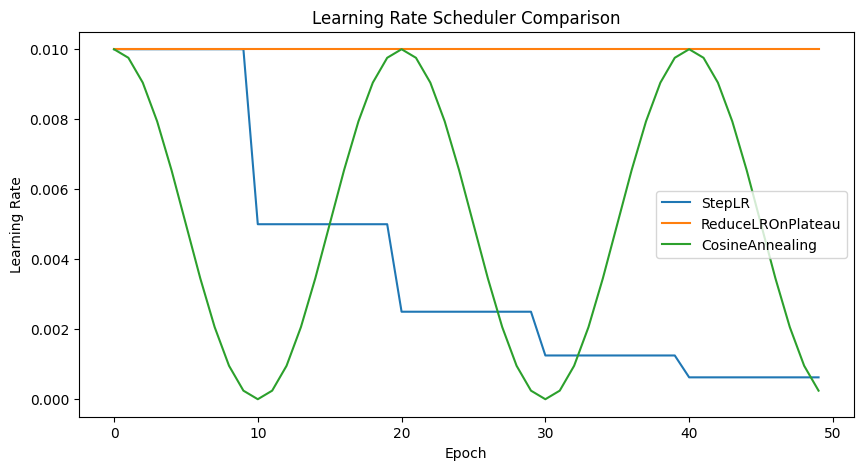

In [14]:
def plot_lr_schedules(results):
    plt.figure(figsize=(10, 5))
    
    for name, result in results.items():
        plt.plot(result['lr_history'], label=name)
    
    plt.title('Learning Rate Scheduler Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.show()

def main():
    X_train, X_test, y_train, y_test = prepare_data()
    results = train_schedulers(X_train, X_test, y_train, y_test)
    plot_lr_schedules(results)

if __name__ == "__main__":
    main()